# Ściąganie epitopów dla modelu
### Wzięte epitopy z organizmu człowieka 

In [ ]:
import pandas as pd
#4zqk

In [ ]:
positive_read = pd.read_csv(r'C:\Studia\AdAm\Positive\positive.csv',usecols = ['Epitope - Name'])
negative_read = pd.read_csv(r'C:\Studia\AdAm\Negative\negative.csv',usecols = ['Epitope - Name'])

positive = pd.DataFrame(positive_read)
negative = pd.DataFrame(negative_read)


In [ ]:

do_wyrzucenia = []            #potrzebne bo w petli baza sie aktualizuje dlatego moze skipowac >30
positive.dropna()
for i in positive.index:
    length = len(str(positive.loc[i]['Epitope - Name']))
    if length > 30 or length ==0:
        do_wyrzucenia.append(i)
positive.drop(index=do_wyrzucenia, inplace=True)
positive

do_wyrzucenia2 = []            
negative.dropna()
for i in negative.index:
    length = len(str(negative.loc[i]['Epitope - Name']))
    if length > 30 or length ==0:
        do_wyrzucenia2.append(i)
negative.drop(index=do_wyrzucenia2, inplace=True)
negative


In [ ]:

positive['Epitope - Name'] = positive['Epitope - Name'].astype(str)  
positive['Epitope - Name'] = positive['Epitope - Name'].apply(
    lambda x: x + '-' * (30 - len(x)) if len(x) < 30 else x)

negative['Epitope - Name'] = negative['Epitope - Name'].astype(str)  
negative['Epitope - Name'] = negative['Epitope - Name'].apply(
    lambda x: x + '-' * (30 - len(x)) if len(x) < 30 else x)

In [ ]:
positive.insert(1,'assay',1)
negative.insert(1,'assay',0)


In [ ]:
equal = pd.concat([positive,negative], ignore_index=True)
equal.drop_duplicates(subset=['Epitope - Name'], inplace=True)
equal.rename(columns={'Epitope - Name':'Sequence'}, inplace=True)
equal

# Czyszczenie danych pod model

In [ ]:
import pandas as pd



pos = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\positive_clean.csv', low_memory=False)
neg = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\negative_clean.csv', low_memory=False)


def remove_dashes(df):
    return df.apply(lambda col: col.str.replace('-', '', regex=False) if col.dtype == 'object' else col)

df = remove_dashes(pos)
df1 = remove_dashes(neg)

df.to_csv('C:\\Studia\\Progranmy\\Adam\\positive_clean2.csv', index=False)
df1.to_csv('C:\\Studia\\Progranmy\\Adam\\negative_clean2.csv', index=False)


In [ ]:
import pandas as pd


pos = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\positive_clean2.csv', low_memory=False)
neg = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\negative_clean2.csv', low_memory=False)


def joiin(df_pos, df_neg):
    combined = pd.concat([df_pos, df_neg], ignore_index=True)    
    return combined

equal = joiin(pos, neg)

print(equal.head())

# Zapisz wynik (opcjonalnie)
equal.to_csv(r'C:\\Studia\\Progranmy\\Adam\\sum.csv', index=False)

# Główny model
### Klasyfikuje na podstawie ... czy w jakiś sposób jest immunogenny

In [ ]:
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#praise Lana cause without her this shi wouldnt work

#przygotowanie csv z poprawnymi aminokwasami
'''
df = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\sum.csv', low_memory=False)
aminokwasy = set('ACDEFGHIKLMNPQRSTVWY')

def czy_valid(seq): #sprawdzanie poprawnych
    return isinstance(seq, str) and all(aa in aminokwasy for aa in seq) and len(seq) <= 30

df_valid = df[df['Epitope - Name'].apply(czy_valid)]
df_valid.to_csv(r'C:\\Studia\\Progranmy\\Adam\\valid_sequences.csv', index=False)

#print(f"Zapisano {len(df_valid)} poprawnych sekwencji do pliku 'valid_sequences.csv'")
'''
#cieply_encode
aminokwasy2 = 'ACDEFGHIKLMNPQRSTVWY'
aa_to_index = {aa: i for i, aa in enumerate(aminokwasy2)}

def wektorowanie(seq, max_len=30):
    encoded = np.zeros((max_len, 20), dtype=int)

    for i, aa in enumerate(seq):
        encoded[i, aa_to_index[aa]] = 1  

    return encoded.flatten()  

#przygotowanie czytalnego datasetu dla pytorcha
class PepDataset(Dataset):
    def __init__(self,df,max_len=30):
        self.max_len = max_len
        self.sequences = df['Epitope - Name'].tolist()
        self.labels = df['assay'].astype(np.float32).tolist()
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, index):
        sequence = self.sequences[index]
        label = self.labels[index]
        encode = wektorowanie(sequence, self.max_len)
        x = torch.tensor(encode, dtype=torch.float32)
        y = torch.tensor(label, dtype=torch.float32)
        
        return x, y

#stworzenie modelu (ktory zadziala za 1 razem)
class Bodygoals(nn.Module):
    def __init__(self,input_size=600):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128), #normalizacja, ktora wspiera stabilizacje i przyspiszenia uczenie - kinda cool ngl
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.model(x)    
        
#budowanie nadzorcy dla goata    
def locked_in(model, dataset, batch_size=32, epochs=20, lr=0.001):
    dataloader = DataLoader(dataset,batch_size=batch_size, shuffle=True)
    crit = nn.BCEWithLogitsLoss() #dziala szybciej (nie musi byc sigmoid juz liczony w modelu)
    poprawiacz = optim.Adam(model.parameters(),lr=lr)
    model.to(device)
    
    print('OKAYYYY LETS GO')
    for epoch in range(epochs):
        model.train()
        biegnaca_strata = 0.0
        
        for i, (x_batch,y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            poprawiacz.zero_grad()
            outputs = model(x_batch)
            outputs = outputs.view(-1)
            loss = crit(outputs, y_batch)
            loss.backward()
            poprawiacz.step()
            biegnaca_strata += loss.item()
        avg_loss = biegnaca_strata / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")
    torch.save(model.state_dict(), "modelImmu.pt")
    print("Model zapisany")

#budowanie egzaminatora
def evaluate_model(model, dataset, batch_size=32):
    dataloader = DataLoader(dataset, batch_size=batch_size)  
    model.eval()     
    model.to(device)
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            outputs = torch.sigmoid(model(x_batch)).view(-1) #handluje ten nowy zrobiony loss, zeby dalej bylo [0,1]

            predicted = (outputs >= 0.5).float()
            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print("Ewaluacja modelu:")
    print(f"Accuracy :  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall   :  {rec:.4f}")
    print(f"F1 Score :  {f1:.4f}")


#przygotowanie danych do treningu
df = pd.read_csv(r'C:\\Studia\\Progranmy\\Adam\\valid_sequences.csv')
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = PepDataset(df_train)
test_dataset = PepDataset(df_test)


#2 year time skip type shi
model = Bodygoals(input_size=600)
locked_in(model, train_dataset, batch_size=32, epochs=20, lr=0.001)
'''
#Sabody arc
model = Bodygoals(input_size=600)
model.load_state_dict(torch.load("C:\\Studia\\Progranmy\\Adam\\modelImmu.pt", map_location=device, weights_only=True))
model.to(device)
'''

#matura
#evaluate_model(model, test_dataset)

#we can finnaly use this fker
def Venator(model, sequence, max_len=30):
    valid_aa = set('ACDEFGHIKLMNPQRSTVWY')
    if not isinstance(sequence, str) or any(aa not in valid_aa for aa in sequence):
        print("Błędna sekwencja: zawiera niepoprawne znaki.")
        return

    if len(sequence) > max_len:
        print(f"Błędna długość: sekwencja ma {len(sequence)}, a dopuszczalne to {max_len}")
        return

    encoded = wektorowanie(sequence, max_len)
    x = torch.tensor(encoded, dtype=torch.float32).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(x).item()

    print(f"Sekwencja: {sequence}")
    print(f"Probability: {output:.4f}")
    if output >= 0.5:
        print("Model przewiduje: AKTYWNA (1)")
    else:
        print("Model przewiduje: NIEAKTYWNA (0)")

#Venator(model, "GIDSSHPDLKVAGGA")


# Wykres dekompozycji energii wykonany metodą MM/GBSA za pomocą serwera HawkDock

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
data = pd.read_csv('PD1-1746613097046.csv')
df = data[["RESIDUE_ID", "TOTAL"]]

df.drop(index=df.index[0], axis=[0], inplace=True)
df

In [ ]:
res = df["RESIDUE_ID"].tolist()
energy = df["TOTAL"].tolist()

In [ ]:
res_numb = []
for i in range(len(res)):
    new_res = res[i]+str(i)
    res_numb.append(new_res)
    

In [ ]:
x = []
for i in range(len(res_numb)):
    x.append(i)

In [ ]:
fig, ax = plt.subplots(figsize=(90,20))
plt.bar(res_numb,energy)
#plt.title
#plt.xlabel
#plt.ylabel
plt.ylim([-10,4.8])
plt.xticks(rotation = 90)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.savefig('plot.png')
plt.show()

# Wizualizacja Unres
### kompleks PDL-1 z LAPKAQIKESLR


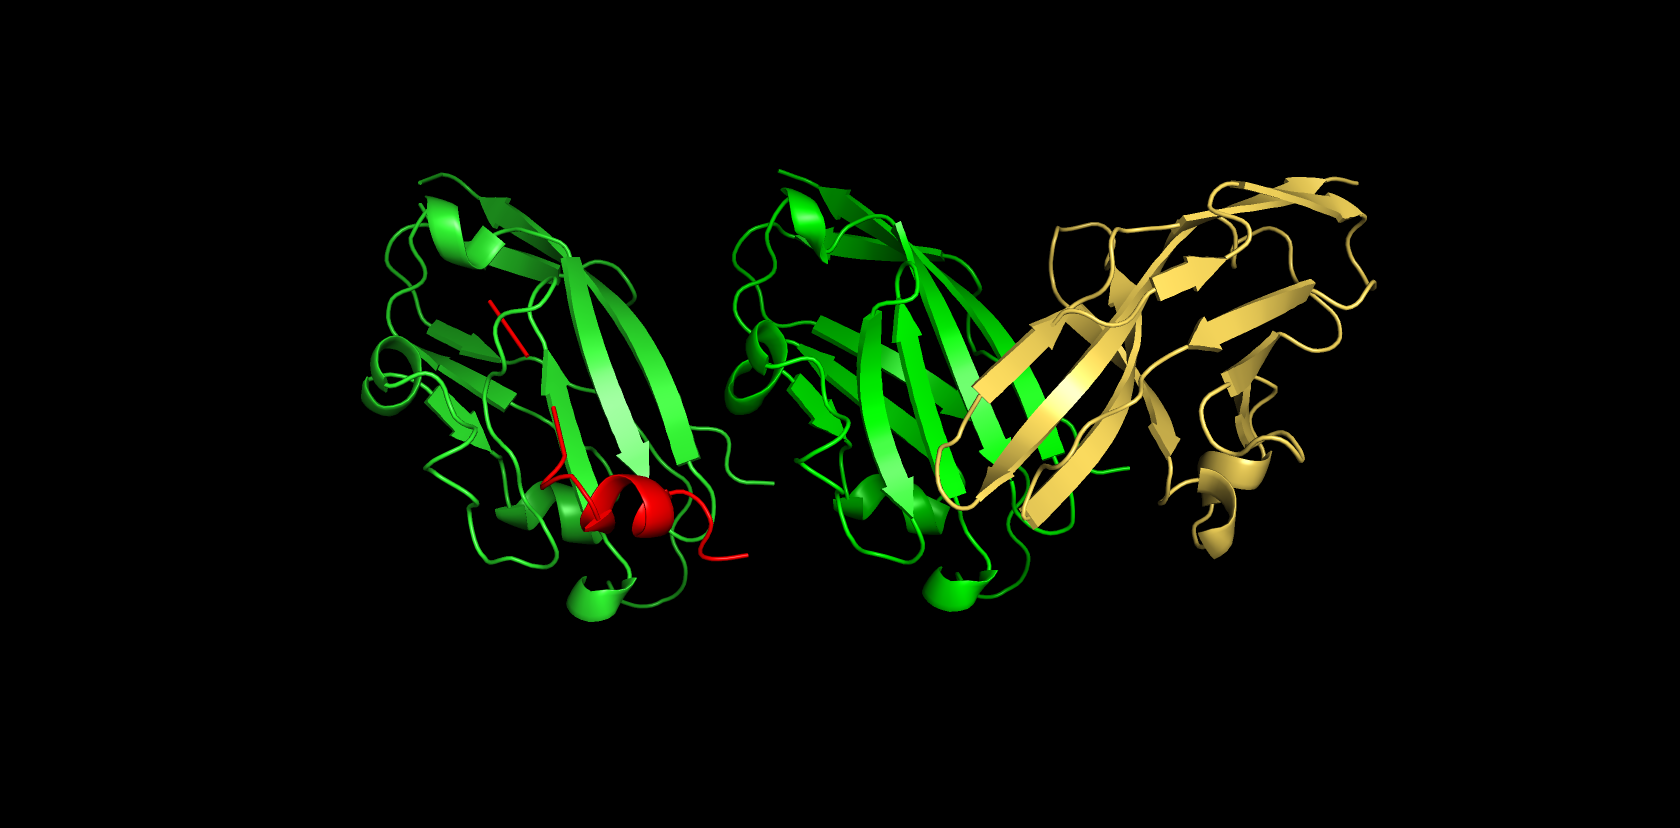